In [1]:
# import all the libraries we need
import os

import parsl
from parsl import python_app
from parsl.config import Config
from parsl.channels import LocalChannel
from parsl.executors import HighThroughputExecutor
from parsl.providers import LocalProvider

# helpers (these wrap the PDG functions in the following modules)
from grouputils import initialize_stager
from grouputils import plot_tiles


## Background

The first step in our workflow is to "stage" our data. Staging the data encompasses the following pre-processing tasks:

- simplify the polygons 
- set an input CRS if one is missing
- reproject the data when required
- add additional properties to each polygon, including: the centroid x and y
  coordinates, the area, a unique ID, and the name of the file that the
  polygon originated from
- break each input file into [standardized tiles](https://docs.opengeospatial.org/is/17-083r2/17-083r2.html), and save them to disk.
- as the polygons are overlaid, the polygons that overlap are de-duplciated (later?)

Here is a diagram showing what the most important step, the last one, looks like.

![](https://raw.githubusercontent.com/PermafrostDiscoveryGateway/viz-staging/develop/docs/images/staging_tldr.png)

We will use some methods from the `pdgstaging` library to stage our tiles. The first step, is to initalize the `TileStager`. The `TileStager` is a class with a method `stage`, which works on a single vector file.

### Initalize the stager

Fist we need to use the `initialize_stager` function to instantiate the `TileStager` object. The only argument to this function is `dir_input`, the directory of input data.

Input vector files are located **in `/home/shares/example-pdg-data`**

In [2]:
# execute the initialize_stager function with the appropriate arguments
# save the result to a variable called iwp_stager
iwp_stager = initialize_stager("/home/shares/example-pdg-data")
# tile satger class is specific to the PDG library

Feel free to explore the `iwp_stager` object in any way you like.

Next let's use it to get a list of files to stage.

In [3]:
files_to_stage = iwp_stager.tiles.get_filenames_from_dir('input')
# this generates a list of files to stage

In [4]:
files_to_stage

['/home/shares/example-pdg-data/GE01_20110819222510_10504100013C6A00_11AUG19222510-M1BS-054019208110_01_P004_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/GE01_20180907225316_1050010012146100_18SEP07225316-M1BS-502583898040_01_P001_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/GE01_20180907225323_1050010012146100_18SEP07225323-M1BS-502583898040_01_P003_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/QB02_20060817224711_101001000525AC00_06AUG17224711-M1BS-052220659010_01_P001_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/QB02_20080807222306_101001000864C800_08AUG07222306-M1BS-052800731090_01_P002_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/QB02_20080807222309_101001000864C800_08AUG07222309-M1BS-052800731090_01_P003_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/QB02_20080807222313_101001000864C800_08AUG07222313-M1BS-052800731090_01_P004_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/QB02_20080827224418_10100100087DAC00_08AUG27

## Stage one file

Here is an example of how to run the stager on one file. We use the `stage` method on the `iwp_stager` object, with a path to a file as the argument to the method.

In [5]:
# grab the first file
example_file = files_to_stage[0]
# stage that one file
iwp_stager.stage(example_file)

Based on how long staging one file took, estimate how long that would take to stage all the input files that we have in this example, serially. How long would it take if we had 100 files? 1000?

In [ ]:
# estimate computation time

For these example data, the amount of time it takes is not super high. But as the number of files gets bigger, things get out of hand quickly. Luckily for us, this problem is pleasingly parallel. The staging of each file is completely independent of the others. So, let's set this up as a `parsl` workflow using the skills we learned in Section 4. 

Just to get a sense of what happened, let's plot the result of our test staging effort using a `plot_tiles` helper we wrote for this activity.

118 are present.             Only plotting the first 45 files.


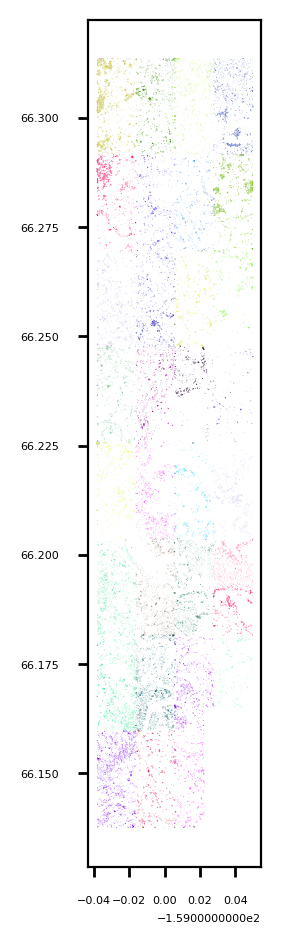

In [6]:
plot_tiles(iwp_stager)

Finally, let's remove the files we just created (including the staging summary csv file) to prepare to run this over all of the files. If we don't do this polygons will get appended to the staged files which will result in duplication.

In [4]:
os.system(f'rm -rf {iwp_stager.config.get("dir_staged")}')
os.system(f'rm {iwp_stager.config.get("filename_staging_summary")}')

rm: cannot remove 'staging_summary.csv': No such file or directory


256

### Staging in parallel

First set up the configuration for `parsl` using `config`, and a `HighThroughputExecutor`. For the executor, set the `max_workers` to 32, and the `max_blocks` for the `provider` to 1. This will spread our work over 32 processes on the server. Make sure you pass the bash command you use to invoke your virtual environment to the `worker_init` argument as a string. (workon scomp)

In [5]:
 activate_env = 'workon scomp'

 htex_config = Config(
   executors = [
       HighThroughputExecutor(
            max_workers = 32,
            provider = LocalProvider(
                worker_init = activate_env,
                max_blocks = 1)
       )
   ]
 )

parsl.clear()
parsl.load(htex_config)

Next, set up your Parsl app to run the `stage` method in parallel. You'll need to pass as arguments to the app function the `TileStager` instance we created earlier. This will be a function with the decorator, the args are a path to a file (or files) and the stager itself (iwp stager).

In [8]:
# Make a Parsl app that uses the stage method
# Decorators seem to be ignored as the first line of a cell, so print something first
print("Stage in parallel")

@python_app
def parallel_stager(path, stager):
    staged_path = stager.stage(path)

Stage in parallel


Now, execute the app in parallel over all of the `files_to_stage`.

In [9]:
# execute the app using app.futures, using a loop
app_futures = []
for path in files_to_stage:
    app_future = parallel_stager(path, iwp_stager)
    print(app_future)
    app_futures.append(app_future)

done = [app_future.result() for app_future in app_futures]
print(done)


<AppFuture at 0x7f6de76c0f40 state=pending>
<AppFuture at 0x7f6de77fb670 state=pending>
<AppFuture at 0x7f6de790fa90 state=pending>
<AppFuture at 0x7f6de790fbb0 state=pending>
<AppFuture at 0x7f6de790fe80 state=pending>
<AppFuture at 0x7f6d37cf8c40 state=pending>
<AppFuture at 0x7f6d37cf8970 state=pending>
<AppFuture at 0x7f6d37cf8820 state=pending>
<AppFuture at 0x7f6de795abb0 state=pending>
<AppFuture at 0x7f6de78c9910 state=pending>
<AppFuture at 0x7f6de76c7970 state=pending>
<AppFuture at 0x7f6de76c7f70 state=pending>
<AppFuture at 0x7f6d37cf8e20 state=pending>
<AppFuture at 0x7f6de791e0d0 state=pending>
<AppFuture at 0x7f6de7964670 state=pending>
<AppFuture at 0x7f6de7964250 state=pending>
<AppFuture at 0x7f6de7964880 state=pending>
<AppFuture at 0x7f6de791c310 state=pending>
<AppFuture at 0x7f6de791c070 state=pending>
<AppFuture at 0x7f6de791c640 state=pending>
<AppFuture at 0x7f6de786e130 state=pending>
<AppFuture at 0x7f6de77a91f0 state=pending>
<AppFuture at 0x7f6de791af70 sta

In [1]:
# Shutdown the executor and clear the parsl engine
htex_config.executors[0].shutdown()
parsl.clear()

NameError: name 'htex_config' is not defined

In [ ]:
# don't forget to shutdown and clear your executor

Now we can check out the `plot_tiles` result again (which will only plot the first 92 of our tiled files)

In [ ]:
plot_tiles(iwp_stager)

## Bonus

This process took the original 35 files, ranging in size from 20MB to 500MB (6 GB total), and tiled them into arond 2200 files, and if you set up your executor like we described, it should have taken around 15 minutes. 

Discuss in your groups whether you suspect this process is CPU bound, I/O bound, memory bound, or network bound. How would you figure it out for sure? Why would you want to know?

### Answer

